# Загрузка Pandas и очистка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import datetime

In [2]:
df = pd.read_csv('main_task.xls')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


<AxesSubplot:>

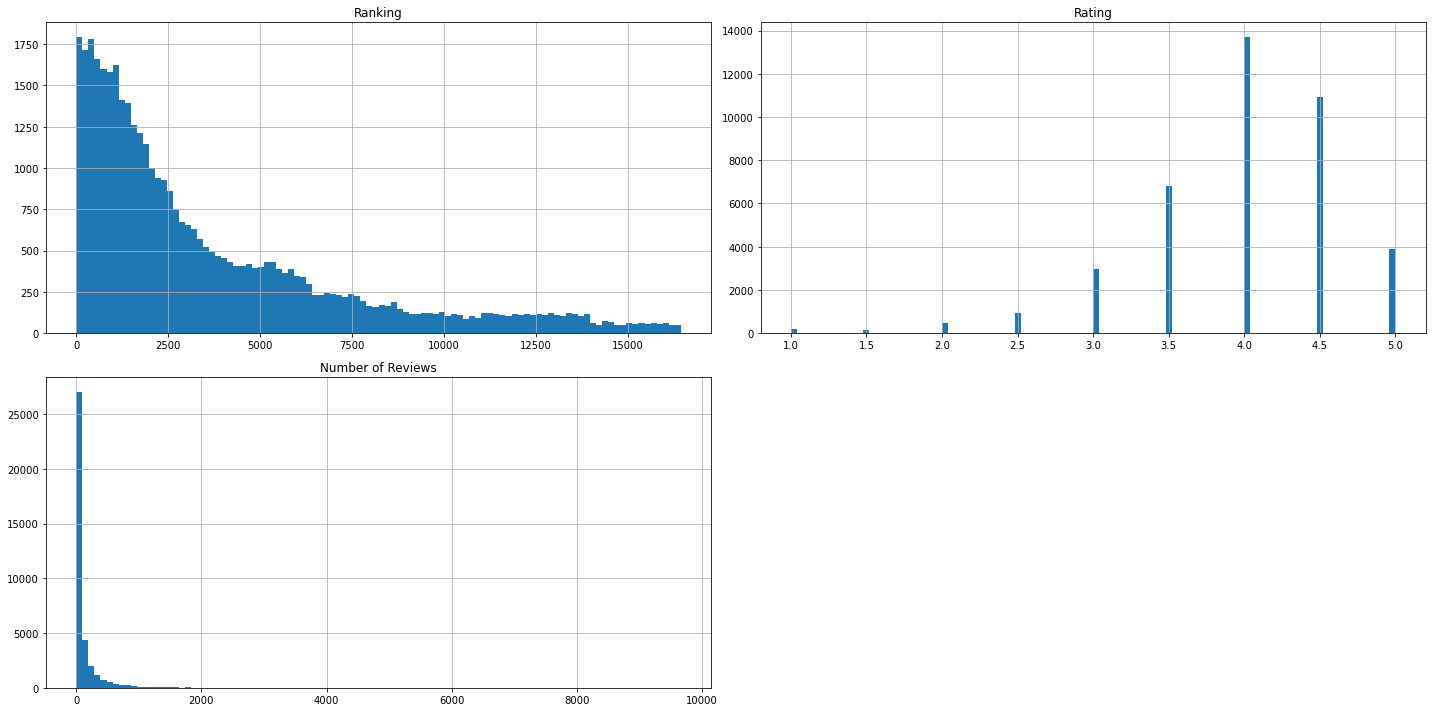

In [3]:
#гистограммы числовых признаков
df[['Ranking', 'Rating', 'Number of Reviews','Price Range', 'Restaurant_id']].hist(figsize=(20, 10), bins=100);
plt.tight_layout()
#гистограмма по городам
df['City'].value_counts(ascending=True).plot(kind='barh')

In [4]:
df['Price Range'] = df['Price Range'].fillna('$$ - $$$')
recode_price={'$':0, '$$ - $$$':1, '$$$$':2}
df['Price Range'] = df['Price Range'].replace(recode_price) #кодирование ординального признака

In [5]:
df['Number of Reviews'] = df['Number of Reviews'].fillna(0) #отзывы отсутствуют

In [6]:
def str_to_list(field): #приведение строкового поля к виду списка 
    if pd.isna(field):
        return ['Other']
    else:
        field = field.replace("'","")
        field = field.replace("]","")
        field = field.replace("[","")
        field = field.split(", ")
        return field
        
df['Reviews'] = df['Reviews'].apply(str_to_list)
df['Cuisine Style'] = df['Cuisine Style'].apply(str_to_list)

In [7]:
from sklearn.preprocessing import MultiLabelBinarizer
#разбитие Cuisine Style на dummy-столбцы
multilabelbinarizer = MultiLabelBinarizer()
multilabel_encoded_results = multilabelbinarizer.fit_transform(df['Cuisine Style'])
df_multilabel_data = pd.DataFrame(multilabel_encoded_results, columns=multilabelbinarizer.classes_)
df = df.join(df_multilabel_data)

df['Cuisine Count'] = df['Cuisine Style'].apply(len) #количество кухонь, представленных в ресторане

In [8]:
pattern = re.compile("\d+\/\d+\/\d+")
df['Reviews'] = df['Reviews'].apply(lambda x: " ".join(x))
df['Date of Reviews'] = df['Reviews'].apply(pattern.findall)  #поиск дат в списке Reviews

def last_review(field): #поиск даты последнего отзыва
    if len(field) == 0:
        return 0
    elif len(field) == 1:
        return field[0]
    else:
        return max(field)

def since_last_review(date):   #подсчет количества дней с последнего отзыва
    if date == 0:
        return 0
    today = datetime.datetime.today()
    if date[:2] > '12':
        date = datetime.datetime.strptime(date, '%d/%m/%Y')
    else:
        date = datetime.datetime.strptime(date, '%m/%d/%Y')
    delta = today - date
    return delta.days

df['Date of Reviews']=df['Date of Reviews'].apply(last_review) #дата последнего отзыва
df['Days Since Last Review'] = df['Date of Reviews'].apply(since_last_review) #количество дней с последнего отзыва

In [9]:
population = {'Paris':2.13, 'Stockholm':1.25, 'London':7.55, 'Berlin':3.32, 'Munich':1.36, 'Oporto':0.29,
       'Milan':1.23, 'Bratislava':0.41, 'Vienna':1.76, 'Rome':2.32, 'Barcelona':1.59, 'Madrid':3.25,
       'Dublin':4.92, 'Brussels':1.01, 'Zurich':0.4, 'Warsaw':1.72, 'Budapest':1.74, 'Copenhagen':1.15,
       'Amsterdam':0.87, 'Lyon':0.49, 'Hamburg':1.71, 'Lisbon':0.54, 'Prague':1.16, 'Oslo':0.67,
       'Helsinki':0.57, 'Edinburgh':0.46, 'Geneva':0.19, 'Ljubljana':0.27, 'Athens':3.16,
       'Luxembourg':0.62, 'Krakow':0.75}
country = {'Paris':'France', 'Stockholm':'Sweden', 'London':'United Kingdom', 'Berlin':'Germany', 'Munich':'Germany',
           'Oporto':'Portugal', 'Milan':'Italy', 'Bratislava':'Slovakia', 'Vienna':'Austria', 'Rome':'Italy',
           'Barcelona':'Spain', 'Madrid':'Spain', 'Dublin':'Ireland', 'Brussels':'Belgium', 'Zurich':'Switzerland', 
           'Warsaw':'Poland', 'Budapest':'Hungary', 'Copenhagen':'Denmark', 'Amsterdam':'Netherlands', 'Lyon':'France',
           'Hamburg':'Germany', 'Lisbon':'Portugal', 'Prague':'Czech Republic', 'Oslo':'Norway', 'Helsinki':'Finland',
           'Edinburgh':'United Kingdom', 'Geneva':'Switzerland', 'Ljubljana':'Slovenia', 'Athens':'Greece',
           'Luxembourg':'Luxembourg', 'Krakow':'Poland'}
df['City Population (mln)'] = df['City'].replace(population) #население города, в котором находится ресторан
df['Country'] = df['City'].replace(country)  #страна, в которой находится ресторан
df = df.join(pd.get_dummies(df['Country']))

In [10]:
df = df.drop(df.select_dtypes(include=['object']),axis=1)

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [11]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop([ 'Rating'], axis = 1)
y = df['Rating']

In [12]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [13]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [14]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [15]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [16]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.20895450000000002
